In [2]:
import re
import os
import random
import numpy as np

from IPython.display import SVG

from collections import namedtuple

os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(42)
random.seed(12345)

from keras.models import Sequential, Model
from keras.layers import Input, Dense, Embedding, Flatten
from keras.layers import Conv1D, MaxPooling1D
from keras.layers import concatenate
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.utils.vis_utils import model_to_dot

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

# Load Datasets

## TREC - Question Answering (multi-class)

In [3]:
# TREC - Question Answering
# http://cogcomp.cs.illinois.edu/Data/QA/QC/

TREC_Question = namedtuple("TREC_Question", "label question")

trec_train = set()
trec_test = set()

for filename in os.listdir("TREC/"):
    with open("TREC/"+filename,'r', encoding='latin_1') as f_input:
        for line in f_input:
            label, question = line.split(' ', 1)
            label = label.split(':')[0]
            question = TREC_Question(label, question)
            if filename=='TREC_10.label':
                trec_test.add(question)
            else:
                trec_train.add(question)

print("Train Samples: {}".format(len(trec_train)))
print("Test Samples : {}".format(len(trec_test)))

Train Samples: 5381
Test Samples : 500


# Possible labels

In [4]:
{x.label for x in trec_train}

{'ABBR', 'DESC', 'ENTY', 'HUM', 'LOC', 'NUM'}

## Stanford Sentiment Treebank - movie reviews with fine-grained labels

In [5]:
# Stanford Sentiment Treebank - movie reviews with fine-grained labels
# https://nlp.stanford.edu/sentiment/

ST_sentence = namedtuple("Stanford_Sentiment", "id sentence")
ST_score = namedtuple("Stanford_Sentiment", "id score")

sentences = []
scores = []
train = []
dev = []
test = []

for filename in ['datasetSentences.txt','datasetSplit.txt', 'sentiment_labels.txt']:
    with open("ST/"+filename,'r') as f_input:
        for line in f_input:
            
            # skip headers
            if line.startswith("sentence_index") or line.startswith('phrase id'):
                    continue
            
            # load sentences
            if filename=='datasetSentences.txt':                                
                sent_id, sentence = line.split('\t', 1)
                sample = ST_sentence(sent_id, sentence)
                sentences.append(sample)
            
            # load splits
            if filename=='datasetSplit.txt':
                sent_id, split = line.split(',', 1)
                split = int(split.strip())
                if split == 1:                    
                    train.append(sent_id)
                if split == 2:                                        
                    test.append(sent_id)
                if split == 3:
                    dev.append(sent_id)
            
            # sentences_id        
            if filename=='sentiment_labels.txt':                    
                sent_id, sent_score = line.split('|', 1)
                #sent_score = float(sent_score.strip())
                sample = ST_score(sent_id, float(sent_score.strip()))
                scores.append(sample)
                    
print("Total Nr. Samples: {}".format(len(sentences)))
print("Total Nr. Scores : {}".format(len(scores)))
print("Train  : {}".format(len(train)))
print("Dev    : {}".format(len(dev)))
print("Test   : {}".format(len(test)))

Total Nr. Samples: 11855
Total Nr. Scores : 239232
Train  : 8544
Dev    : 1101
Test   : 2210


In [6]:
{y.score for y in scores}

{0.0,
 0.013889,
 0.027778,
 0.041667,
 0.055556,
 0.069444,
 0.083333,
 0.097222,
 0.11111,
 0.125,
 0.13542,
 0.13889,
 0.14583,
 0.15278,
 0.16667,
 0.17708,
 0.18056,
 0.19444,
 0.19792,
 0.20833,
 0.21875,
 0.22222,
 0.23611,
 0.23958,
 0.24306,
 0.25,
 0.26042,
 0.26389,
 0.27083,
 0.27778,
 0.28125,
 0.29167,
 0.30208,
 0.30556,
 0.3125,
 0.31944,
 0.33333,
 0.34375,
 0.34722,
 0.35417,
 0.36111,
 0.36458,
 0.375,
 0.38194,
 0.38542,
 0.38889,
 0.39583,
 0.40278,
 0.40625,
 0.41667,
 0.42361,
 0.42708,
 0.43056,
 0.4375,
 0.44444,
 0.44792,
 0.45139,
 0.45833,
 0.46875,
 0.47222,
 0.47917,
 0.48611,
 0.48958,
 0.49306,
 0.5,
 0.50694,
 0.51042,
 0.51389,
 0.52083,
 0.52778,
 0.53125,
 0.54167,
 0.54861,
 0.55208,
 0.55556,
 0.5625,
 0.56944,
 0.57292,
 0.58333,
 0.59028,
 0.59375,
 0.59722,
 0.60417,
 0.61111,
 0.61458,
 0.625,
 0.63194,
 0.63542,
 0.63889,
 0.64583,
 0.65278,
 0.65625,
 0.66667,
 0.67708,
 0.68056,
 0.6875,
 0.69444,
 0.69792,
 0.70833,
 0.71875,
 0.72222,
 0.7

## TODO: transform to classes or also use as regression problem

In [7]:
# (very positive, positive, neutral, negative, very negative), re-labeled by Socher et al. (2013).4

In [8]:
# 0 - 2.0 
# 2.0 - 4.0
# 4.0 - 6.0
# 6.0 - 8.0
# 8.0 - 10.0

## Movie reviews with one sentence per review

In [9]:
# Movie reviews with one sentence per review.
# https://www.cs.cornell.edu/people/pabo/movie-review-data/

# fold 1: files tagged cv000 through cv099, in numerical order
# fold 2: files tagged cv100 through cv199, in numerical order
# fold 10: files tagged cv900 through cv999, in numerical order

folds = [set() for _ in range(10)]
Review = namedtuple("MovieReview", "label sentence")

for directory in ['MR/txt_sentoken/pos/','MR/txt_sentoken/neg/'] :
    for filename in os.listdir(directory) + os.listdir(directory):
        label = directory.split("/")[-2]        
        fold = int(filename.split("_")[0][2])
        with open(directory+filename,'r') as f_input:
            for line in f_input:
                sample = Review(label,line.strip())
                folds[fold].add(sample)

for i, x in enumerate(folds):
    print(i, len(x))

0 6298
1 6138
2 6162
3 6357
4 6655
5 6589
6 6883
7 6551
8 6193
9 6586


In [10]:
{msg.label for fold in folds for msg in fold}

{'neg', 'pos'}

## Customer Review

In [11]:
# CR: http://www.cs.uic.edu/~liub/FBS/sentiment-analysis.html

CustomerReview = namedtuple("Customer_Review", "aspects sentence")
data = []

for filename in os.listdir('CR/'):
    if filename=='Readme.txt':
        continue
    print(filename)
    with open('CR/'+filename,'r') as f_input:
        for line in f_input:
            if line.startswith("*"):
                continue
            # select only lines with an opinion over a feature of the product
            m = re.match(r'.*\[(.[0-9])\].*##.*',line)
            if m:
                sentence = line.split('##')[1].strip()
                aspects_string = line.split('##')[0]
                aspects = aspects_string.split(",")
                data.append(CustomerReview(aspects, sentence))
print(len(data))

Apex AD2600 Progressive-scan DVD player.txt
Canon G3.txt
Creative Labs Nomad Jukebox Zen Xtra 40GB.txt
Nikon coolpix 4300.txt
Nokia 6610.txt
1727


In [12]:
for msg in data:
    if len(msg.aspects) > 1:
        print(msg.aspects)

['player[+2]', 'sound[-1]']
['look[+3]', 'panel button layout[+3]', 'feature[+2]']
['forward[+2]', ' rewind[+2]']
['play[+2]', ' dvd-r[+1]']
['remote control[-1]', ' mp3 filename[-1]']
['play[-2]', ' disney movie[-2]']
['player[+1]', ' look[+3]']
['customer service[-3]', ' technical support[-3]']
['dvd[-2]', ' read[-2]', ' play[-2]']
['picture quality[+2]', 'feature[+2]']
['look[+2]', ' feature[+2]']
['play[-2]', ' dvd[-2]']
['jpeg slideshow[+2]', 'mpeg1[+1]']
['picture[-2]', ' player[-3][p]']
['play[-2]', ' disc[-2]']
['play[-2]', ' dvd[-2]']
['picture[-2]', ' player[-2][p]']
['dvd[-2]', ' play[-2]']
['dvd[-2]', ' play[-2]']
['format[+2][u]', 'progressive scan[+2]']
['play[+2]', ' different file[+2]']
['play[+2]', ' mpeg[+2]']
['no disc[-2]', ' screen[-3][u]']
['player[+3]', ' format[+2]']
['progressive scan[+2]', 'remote[+3]']
['play[-2]', ' dvd[-2]', ' no disc[-2]']
['look[+2][u]', 'panel[+2]']
['dvd[-2]', ' picture[-2]', ' play[-2]']
['picture[-2]', ' sound[-2]']
['dvd[-2]', ' read

# Utils functions

In [19]:
def print_model(model):
    SVG(model_to_dot(model, show_layer_names=True, show_shapes=True).create(prog='dot', format='svg'))

def compute_metrics(raw_predictions, label_encoder):
    # convert raw predictions to class indexes
    threshold = 0.5
    class_predictions = [(x > threshold).astype(int) for x in model.predict(x_test)]
    
    # convert raw predictions to class indexes
    threshold = 0.5
    class_predictions = [(x > threshold).astype(int) for x in model.predict(x_test)]

    # select only one class (i.e., the dim in the vector with 1.0 all other are at 0.0)
    class_index = ([np.argmax(x) for x in class_predictions])

    # convert back to original class names
    pred_classes = label_encoder.inverse_transform(class_index)

    # print precision, recall, f1-score report
    print(classification_report(y_test, pred_classes))

## Prepare training data for input to neural network

In [13]:
max_len = max([len(x.question.split()) for x in trec_train])
questions_train = [x.question for x in trec_train]
labels_train = [x.label for x in trec_train]

# Convert words to indexes
tokenizer = Tokenizer()
tokenizer.fit_on_texts(questions_train)
sequences_train = tokenizer.texts_to_sequences(questions_train)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

# Pad the sequences to the 'max_len'
data_train = pad_sequences(sequences_train, maxlen=max_len)

# Encode the labels, each must be a vector with dim = num. of possible labels
le = LabelEncoder()
le.fit(labels_train)
labels_encoded_train = le.transform(labels_train)
categorical_labels_train = to_categorical(labels_encoded_train, num_classes=None)
print('Shape of train data tensor:', data_train.shape)
print('Shape of train label tensor:', categorical_labels_train.shape)

# Shuffle training data
indices = np.arange(data_train.shape[0])
np.random.shuffle(indices)
x_train = data_train[indices]
y_train = categorical_labels_train[indices]

Found 8461 unique tokens.
Shape of train data tensor: (5381, 37)
Shape of train label tensor: (5381, 6)


In [14]:
# Pre-Process test data
questions_test = [x.question for x in trec_test]
y_test = [x.label for x in trec_test]
sequences_test = tokenizer.texts_to_sequences(questions_test)
x_test = pad_sequences(sequences_test, maxlen=max_len)

print('Shape of test data tensor:', x_test.shape)

Shape of test data tensor: (500, 37)


## Convolutional Neural Networks for Sentence Classification
https://arxiv.org/pdf/1408.5882.pdf

## 3.1 Hyperparameters and Training

For all datasets we use: 

- rectified linear units;
- filterwindows (h) of 3, 4, 5 with 100 feature maps each;
- dropout rate (p) of 0.5;
- l2 constraint (s) of 3;
- mini-batch size of 50;

These values were chosen via a grid search on the SST-2 dev set. 

We do not otherwise perform any dataset specific tuning other than early stopping on dev sets. For datasets without a standard dev set we randomly select 10% of the training data as the dev set. 

Training is done through stochastic gradient descent over shuffled mini-batches with the Adadelta update rule (Zeiler, 2012).

## 3.2 Pre-trained Word Vectors

We use the publicly available:

- word2vec vectors that were trained on 100 billion words from Google News.
- Words not present in the set of pre-trained words are initialized randomly.

## 3.3 Models Variations

## 1) `CNN-rand`: all words are randomly initialized and then modified during training

In [64]:
from keras.layers import concatenate

features_maps = 100
n_grams = [3,4,5]
embedding_dim = 200
vocab_size=1000
max_len=max_len

embedding_matrix = np.random.rand(max_words, embedding_dim)

embedding_layer_dynamic = Embedding(input_dim=embedding_matrix.shape[0],
                                   output_dim=embedding_matrix.shape[1], 
                                   input_length=max_len, 
                                   weights=[embedding_matrix], 
                                   trainable=True, 
                                   name='embedding_layer_dynamic')

i = Input(shape=(max_len,), dtype='int32', name='main_input')
x = embedding_layer_dynamic(i)

# rectified linear units, filter windows (h) of 3, 4, 5 with 100 feature maps each
branches = []
for n in n_grams:
    branch = Conv1D(filters=100, kernel_size=n, name='Conv_'+str(n))(x)
    branch = MaxPooling1D(pool_size=2, strides=None, padding='valid', name='MaxPooling_'+str(n))(branch)
    branch = Flatten(name='Flatten_'+str(n))(branch)
    branches.append(branch)

z = concatenate(branches, axis=-1)
o = Dense(1, activation='sigmoid', name='output')(z)

model = Model(inputs=i, outputs=o)
model.compile(loss={'output': 'binary_crossentropy'}, optimizer='adam')

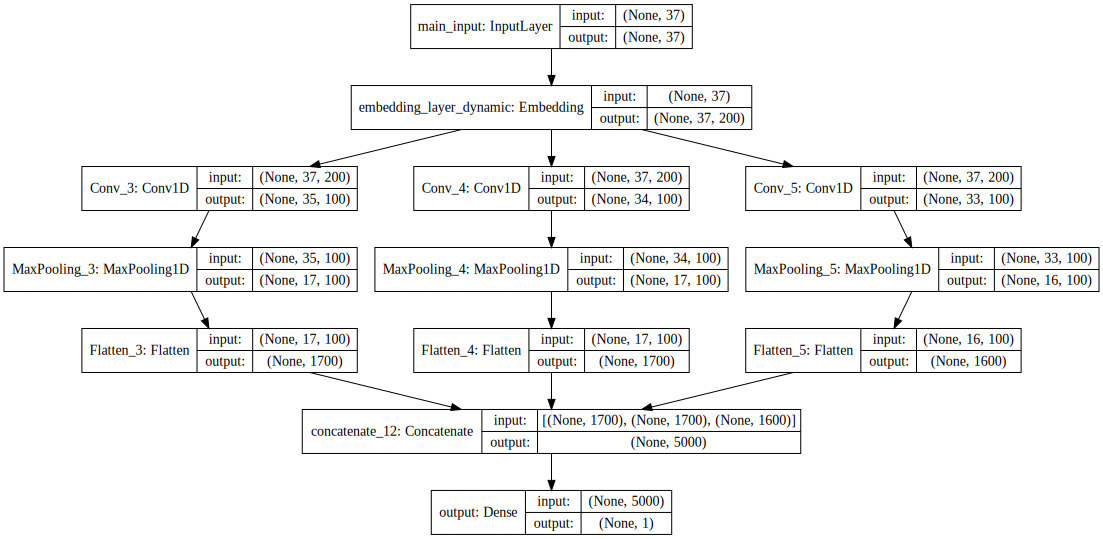

In [65]:
SVG(model_to_dot(model, show_layer_names=True, show_shapes=True).create(prog='dot', format='svg'))

## 2) CNN-static: pre-trained vectors with all the words— including the unknown ones that are randomly initialized—kept static and only the other parameters of the model are learned

## loading GloVe Embeddings

In [68]:
glove_dir = '/Users/dsbatista/resources/glove.6B'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


## Create Embeddings matrix

In [73]:
embedding_dim = 100
max_words = 10000

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [74]:
embedding_layer_static = Embedding(input_dim=embedding_matrix.shape[0],
                            output_dim=embedding_matrix.shape[1], 
                            input_length=max_len, 
                            weights=[embedding_matrix], 
                            trainable=False, 
                            name='embedding_layer_static')

In [75]:
i = Input(shape=(max_len,), dtype='int32', name='main_input')
x = embedding_layer_dynamic(i)

# rectified linear units, filter windows (h) of 3, 4, 5 with 100 feature maps each
branches = []
for n in n_grams:
    branch = Conv1D(filters=100, kernel_size=n, name='Conv_'+str(n))(x)
    branch = MaxPooling1D(pool_size=2, strides=None, padding='valid', name='MaxPooling_'+str(n))(branch)
    branch = Flatten(name='Flatten_'+str(n))(branch)
    branches.append(branch)

z = concatenate(branches, axis=-1)
o = Dense(1, activation='sigmoid', name='output')(z)

model = Model(inputs=i, outputs=o)
model.compile(loss={'output': 'binary_crossentropy'}, optimizer='adam')

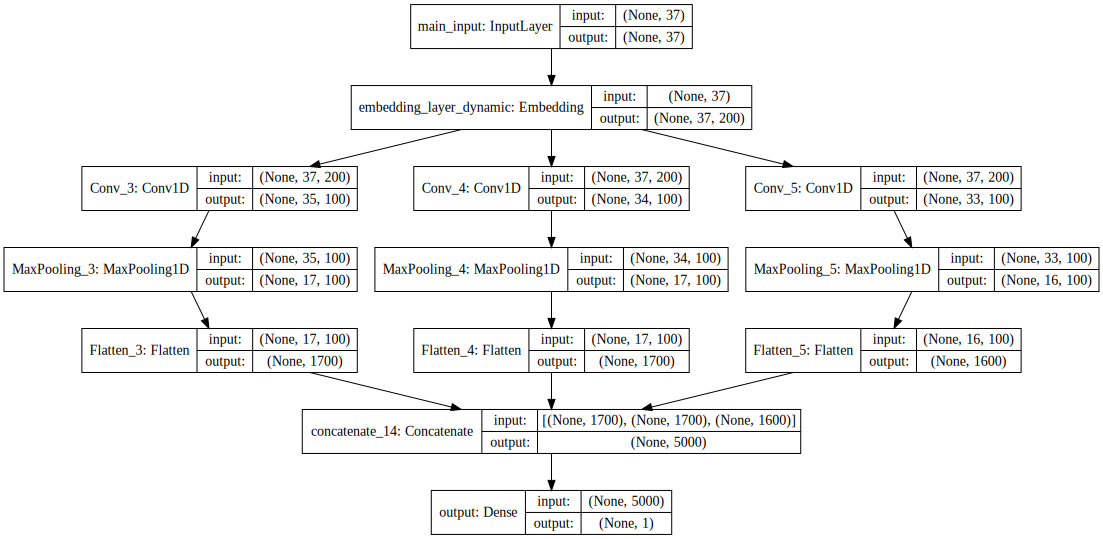

In [76]:
SVG(model_to_dot(model, show_layer_names=True, show_shapes=True).create(prog='dot', format='svg'))

## 3) Same as above but word vectors are fine-tuned

## 4) CNN-multichannel: A model with two sets of word vectors. Each set of vectors is treated as a `channel` and each filter is applied

In [89]:
embedding_layer_dynamic = Embedding(input_dim=embedding_matrix.shape[0],
                                    output_dim=embedding_matrix.shape[1], 
                                    input_length=max_len, 
                                    weights=[embedding_matrix], 
                                    trainable=True, 
                                    name='embedding_layer_dynamic')


embedding_layer_static = Embedding(input_dim=embedding_matrix.shape[0],
                                   output_dim=embedding_matrix.shape[1], 
                                   input_length=max_len, 
                                   weights=[embedding_matrix], 
                                   trainable=False, 
                                   name='embedding_layer_static')

In [93]:
input_static = Input(shape=(max_len,), dtype='int32', name='input_static')
x = embedding_layer_static(input_static)
branches_static = []

for n in n_grams:
    branch = Conv1D(filters=100, kernel_size=n, name='Conv_static'+str(n))(x)
    branch = MaxPooling1D(pool_size=2, strides=None, padding='valid', name='MaxPooling_static'+str(n))(branch)
    branch = Flatten(name='Flatten_static'+str(n))(branch)
    branches_static.append(branch)

    
input_dynamic = Input(shape=(max_len,), dtype='int32', name='input_dynamic')
w = embedding_layer_dynamic(input_dynamic)
branches_dynamic = []

for n in n_grams:
    branch = Conv1D(filters=100, kernel_size=n, name='Conv_dynamic'+str(n))(w)
    branch = MaxPooling1D(pool_size=2, strides=None, padding='valid', name='MaxPooling_dynamic'+str(n))(branch)
    branch = Flatten(name='Flatten_dynamic'+str(n))(branch)
    branches_dynamic.append(branch)

z_static = concatenate(branches_static, axis=-1)
z_dynamic = concatenate(branches_dynamic, axis=-1)    
z = concatenate([z_static,z_dynamic], axis=-1)
o = Dense(6, activation='sigmoid', name='output')(z)

model = Model(inputs=[input_static, input_dynamic], outputs=o)

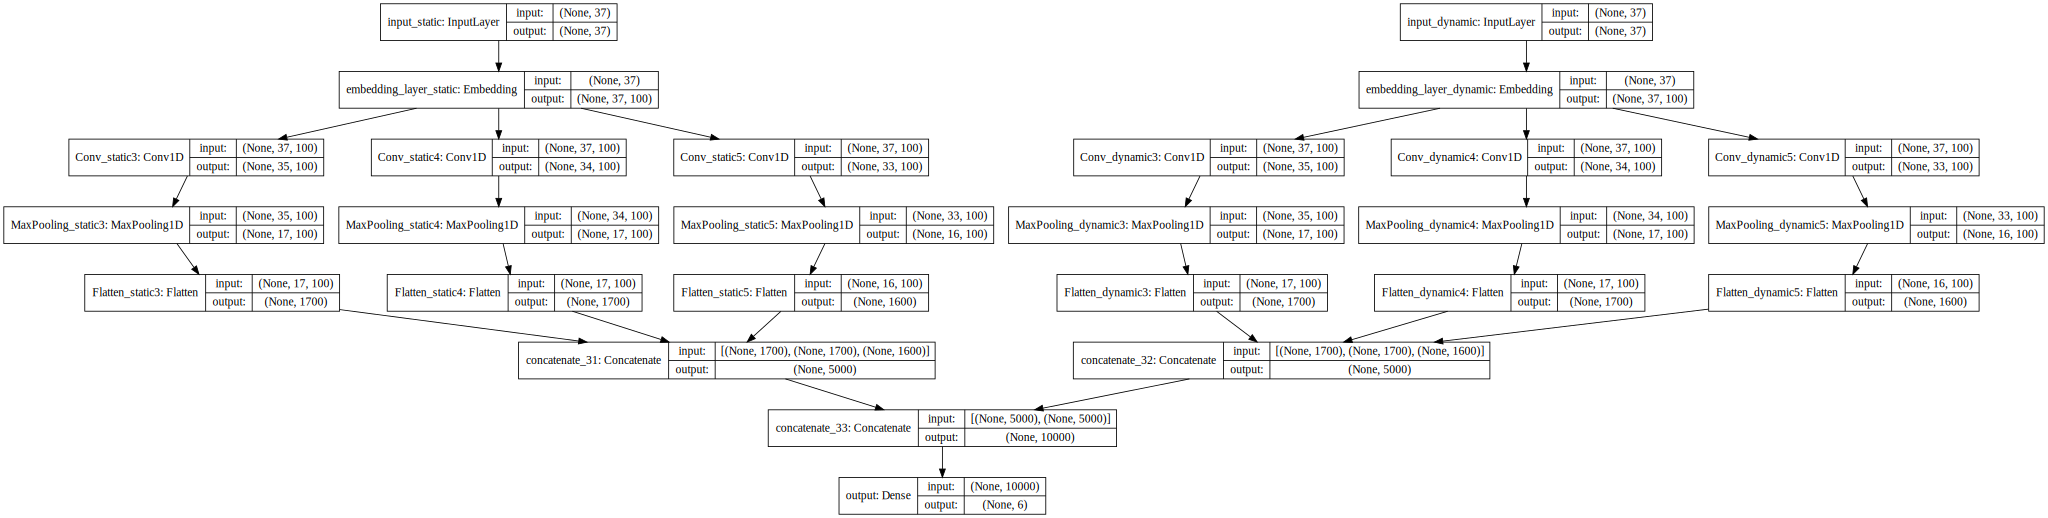

In [94]:
SVG(model_to_dot(model, show_layer_names=True, show_shapes=True).create(prog='dot', format='svg'))